# 2022 NZMSA Data Science Submission.

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

# Exploratory Data Analysis.

In [2]:
dataset = pd.read_csv("weather-data.csv")
dataset.head() # Show the first five results.


,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


In [3]:
dataset.describe() 

,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000,0.0
mean,15.811503,12.115772,79.782307,8.919029,30.962594,NaN
std,4.235197,3.738005,12.562199,5.348379,6.319510,NaN
min,2.000000,-2.000000,29.230000,0.000000,13.000000,NaN
25%,13.000000,9.000000,71.450000,5.000000,27.000000,NaN
50%,16.000000,12.000000,81.990000,8.000000,31.000000,NaN
75%,19.000000,15.000000,88.180000,12.000000,35.000000,NaN
max,29.000000,23.000000,100.000000,42.000000,56.000000,NaN


In [4]:
dataset.info()
dataset["valid"] = pd.to_datetime(dataset["valid"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0    station        103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


<AxesSubplot:>

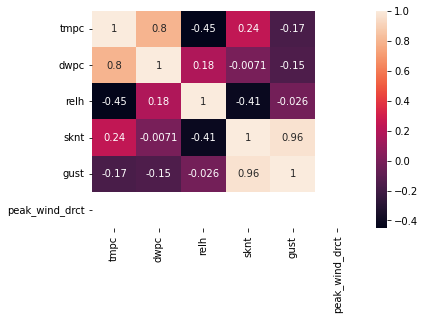

In [5]:
sns.heatmap(dataset.corr(), annot=True)

Text(0, 0.5, 'Wind Gust (Knots)')

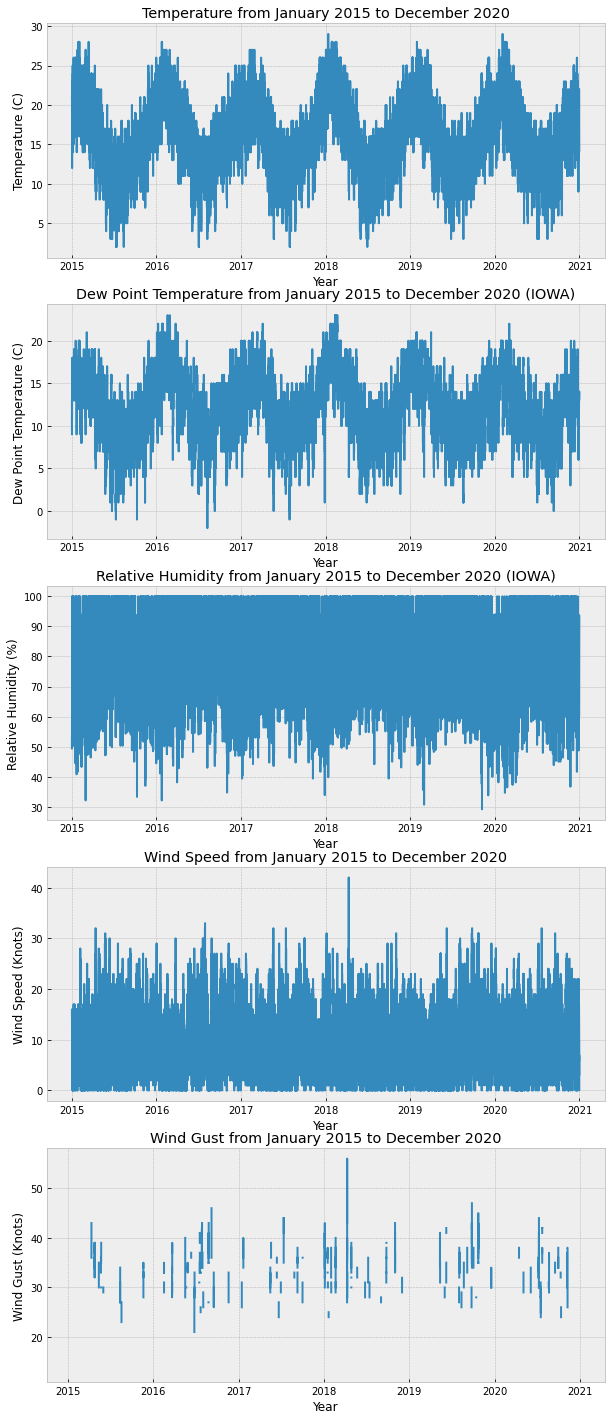

In [6]:
plt.style.use("bmh")
fig, (tmpc, dwpc, relh, sknt, gust) = plt.subplots(5, 1)
fig.set_size_inches(10,25)
fig.subplots_adjust(wspace= 2)

tmpc.plot(dataset["valid"], dataset["tmpc"])
tmpc.set_title("Temperature from January 2015 to December 2020")
tmpc.set_xlabel("Year")
tmpc.set_ylabel("Temperature (C)")

dwpc.plot(dataset["valid"],dataset["dwpc"])
dwpc.set_title("Dew Point Temperature from January 2015 to December 2020 (IOWA)")
dwpc.set_xlabel("Year")
dwpc.set_ylabel("Dew Point Temperature (C)")

relh.plot(dataset["valid"],dataset["relh"])
relh.set_title("Relative Humidity from January 2015 to December 2020 (IOWA)")
relh.set_xlabel("Year")
relh.set_ylabel("Relative Humidity (%)")

sknt.plot(dataset["valid"],dataset["sknt"])
sknt.set_title("Wind Speed from January 2015 to December 2020")
sknt.set_xlabel("Year")
sknt.set_ylabel("Wind Speed (Knots)")

gust.plot(dataset["valid"],dataset["gust"])
gust.set_title("Wind Gust from January 2015 to December 2020")
gust.set_xlabel("Year")
gust.set_ylabel("Wind Gust (Knots)")


# Findings from Exploratory Analysis

 * From the correlation plot, it appears that the dew point temerature and the environment temperature are strongly linearly related to each other. The reading for the wind gust almost depends entirely on the wind speed.

 * Using the same plot, temperature and humidity seem to be weakly (negatively) related to each other, with the same appearing to be true for humidty and wind speed

 * From our plots, it seems that the range of all the measurements stays relatively constant from 2015 to 2020, but we do see that around 2018 there seems to be observations that are more extreme than the rest of the data.

 * The fluctuations that we see (High -> Low) are likely to be a result of seasonal effects

# Data Processing

* Our model aims to predict one month after the last date

* As we saw from the Exploratory Analysis, the spread of our data did not change with increaing/decreasing time

* Therefore we will try to create a model that relates the environmental factors together

* We saw that peak wind direction does not seem to have any influence on the other factors so we will drop it from the model, we will also drop the wind gust as it seems to be identical to wind speed readings with missing values, and also because wind gust does not relate to any other conditions.

* For similar reasons, "Valid" and "Station" will also be dropped.

In [7]:
dataset2 = pd.read_csv("weather-data.csv")
dataset2["valid"] = pd.to_datetime(dataset["valid"])
dataset2.drop(columns=["valid", " station", "peak_wind_drct", "gust"], inplace=True);
dataset2.head()

,tmpc,dwpc,relh,sknt
0,21.0,11.0,52.77,15.0
1,21.0,10.0,49.37,16.0
2,21.0,12.0,56.38,16.0
3,21.0,13.0,60.21,16.0
4,21.0,12.0,56.38,16.0


In [8]:
import numpy as np


dataset2.isnull().sum()

tmpc     35
dwpc     35
relh    120
sknt      9
dtype: int64

We have some null values, but since the data is sampled in 30 minute intervals, we will assume that the changes aren't big, therefore using a forwards fill and assuming that there is no change in that 30 minute interval will be appropriate.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   tmpc    103713 non-null  int64
 1   dwpc    103713 non-null  int64
 2   relh    103713 non-null  int64
 3   sknt    103713 non-null  int64
dtypes: int64(4)
memory usage: 3.2 MB


<AxesSubplot:>

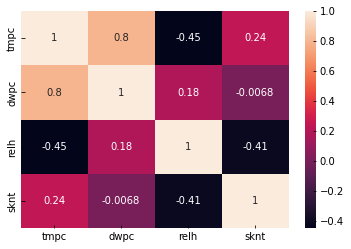

In [9]:
dataset2 = dataset2.fillna(method="ffill")
dataset2.isnull().sum()
dataset2 = dataset2.astype(np.int64)
dataset2.info()
sns.heatmap(dataset2.corr(), annot=True)

Since the models only understand numbers, we will try to fit a model that is able to predict the next timestep's conditions based on the previous. To do this we will set the previous timestamp's values to that of the next. After training our model, we will base the 1 month forecast on December's conditions. Since each timestep is 30 minutes, (24x60x30)/30 = 1440 steps per month.

<AxesSubplot:>

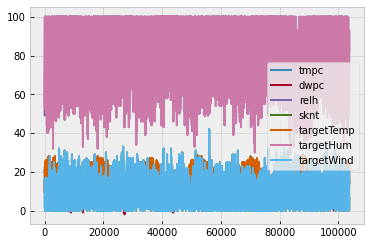

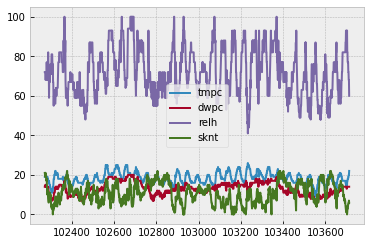

In [10]:
# lets try to format the columns so that we predict the temperature one hour after (called "target")
step = 2
dataset3 = dataset2.copy()
dataset3["targetTemp"] = dataset3.shift(-step)["tmpc"]
dataset3["targetHum"] = dataset3.shift(-step)["relh"]
dataset3["targetWind"] = dataset3.shift(-step)["sknt"]

dataset3 = dataset3.iloc[:-step,:].copy()
dataset3.plot()
testset = dataset2.iloc[-1440:, :].copy() 
testset.plot()

# Data Modelling

I will first declare a function so I can test multiple models before I choose one

In [25]:
from pandas import DataFrame
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

def useModel(variables, toPredict, inputModel):
    model = inputModel
    model.fit(dataset3[[variables]], dataset3[toPredict])
    predictions = model.predict(testset[[variables]])
    update = []

    for i in range(1,3):
        update.append(predictions)
        predictions = model.predict(DataFrame({variables: update[len(update)-1]}))

    update = np.array(update).ravel()
    forecast = DataFrame({toPredict: update})
    forecast.truncate(after=1440).plot()
    scores = cross_val_score(model, dataset3[[variables]], dataset3[toPredict], cv=KFold(shuffle=True))
    x_train, x_test, y_train, y_test =train_test_split(dataset3[[variables]], dataset3[toPredict],test_size=0.5)

    print("The ", inputModel, " score for predicting", toPredict, " is ",model.score(x_test,y_test))
    print("CV score for predicting", toPredict, " ", inputModel, " is:", scores.mean())


After trying out a few models, I came to the conclusion that for this situation a Decision Tree model had the higest accuracy out of all the others.

The  DecisionTreeRegressor(random_state=123)  score for predicting targetTemp  is  0.9480713926237163
CV score for predicting targetTemp   DecisionTreeRegressor(random_state=123)  is: 0.9484232494874345
The  DecisionTreeRegressor(random_state=123)  score for predicting targetHum  is  0.7976249557077748
CV score for predicting targetHum   DecisionTreeRegressor(random_state=123)  is: 0.799165218728883
The  DecisionTreeRegressor(random_state=123)  score for predicting targetWind  is  0.8054604025682642
CV score for predicting targetWind   DecisionTreeRegressor(random_state=123)  is: 0.8039812122790462


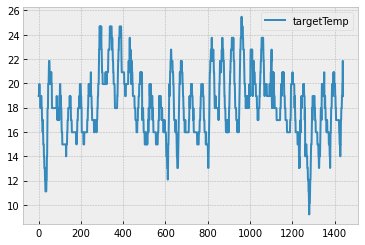

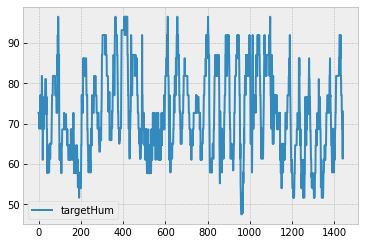

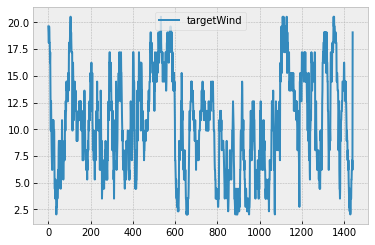

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import  LinearRegression, Ridge
from sklearn import svm

DecisionTreeReg = DecisionTreeRegressor(random_state=123)
useModel("tmpc", "targetTemp",DecisionTreeReg)
useModel("relh", "targetHum",DecisionTreeReg)
useModel("sknt", "targetWind",DecisionTreeReg)


# Conclusion

* I managed to get a decent amount of accuracy on my model, and based the predictions off the previous month (December 2020).

* Initially I tried predicting large timesteps ahead, however that was not accurate because conditions vary a large amount throughout the day due to both time and random weather changes, so I was forced to use a timestamp of one hour, which would at least somewhat account for those factors

* In the end I did not fit multiple variables for predictions to avoid overfitting, as the values did not seem to be very interrelated from my judgement .